In [ ]:
pip install --upgrade tensorflow


In [ ]:
!pip install --upgrade keras


In [ ]:
!pip install keras

In [ ]:
!pip install Keras-Preprocessing


In [1]:
import tensorflow as tf
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [2]:
#moun the drive for saving the models or model charts
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive


In [3]:
def load_doc(filename):
	# open the file as read only

	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "DL_Project_3/Flickr_8k_Text/Flickr_8k.token.txt"

doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [4]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]

		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [ ]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [5]:
def clean_des(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]

			desc = desc.split()
			desc = [word.lower() for word in desc]
			desc = [w.translate(table) for w in desc]

			desc = [word for word in desc if len(word)>1]
			desc = [word for word in desc if word.isalpha()]
			desc_list[i] =  ' '.join(desc)

clean_des(descriptions)

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [6]:
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [7]:
def save_des(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_des(descriptions, 'descriptions.txt')

In [8]:
# load a pre-defined list of photo identifier
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()

	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'DL_Project_3/Flickr_8k_Text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [9]:
#load test
filename = 'DL_Project_3/Flickr_8k_Text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

Dataset: 1000


In [10]:
images = 'DL_Project_3/Flickr_8k_Images/'
img = glob.glob(images + '*.jpg')


In [11]:

train_images_file = 'DL_Project_3/Flickr_8k_Text/Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

train_img = []

for i in img: 
    if i[len(images):] in train_images:
        train_img.append(i) 

In [12]:
test_images_file = 'DL_Project_3/Flickr_8k_Text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = []

for i in img: 
    if i[len(images):] in test_images: 
        test_img.append(i)

In [13]:
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [14]:
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


In [15]:
def preprocess(image_path):
    # convert to 299x299 as expected by the inception v3 model
    #for resnet 224*224
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [16]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 3s 0us/step


In [17]:
from tensorflow.keras.applications import ResNet50
#trying our ResNet50 to extract features
model_resnet=ResNet50(weights='imagenet')

102967424/102967424 [==============================] - 3s 0us/step


In [ ]:
# Create a new model, by removing the last layer (output layer) from the resnet
model_new = Model(model_resnet.input, model_resnet.layers[-2].output)

In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [ ]:

start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [ ]:
import pickle
with open("resnet_encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
import pickle
with open("DL_Project_3/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


I0000 00:00:1712618937.322319      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [ ]:
with open("encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [ ]:
with open("resnet_encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [18]:
train_features = load(open("DL_Project_3/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
train_features = load(open("DL_Project_3/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

In [19]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [20]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1


vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [21]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [22]:
vocab_size = len(ixtoword) + 1 
vocab_size

1652

In [23]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [24]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield (np.array(X1), np.array(X2)), np.array(y)
                X1, X2, y = [],[],[]
                n=0


In [25]:
glove_dir = 'DL_Project_3/glove.6B.200d.txt'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [26]:
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [27]:
embedding_matrix.shape

(1652, 200)

In [28]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 200)              330400    ['input_4[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_3[0][0]']             
                                                                                              

In [ ]:
model.layers[2]

<Embedding name=embedding, built=True>

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [30]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
epochs = 40
model.optimizer.lr = 0.0001
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath
loss_resnet=[]

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    history=model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss_resnet.append(history.history['loss'])

    #model.save('DL_Project_3/model_weight/model_' + str(i) + '.h5')

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 3.5501
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - loss: 3.2716
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 3.1133
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 3.0050
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 57ms/step - loss: 2.9198
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 2.8488
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 2.7894
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 2.7471
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 2.7029
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 2.6679
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - loss: 2.6344
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 2.6059
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 2.5759
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 2.5529
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 2.5298
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - loss: 2.5102
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/

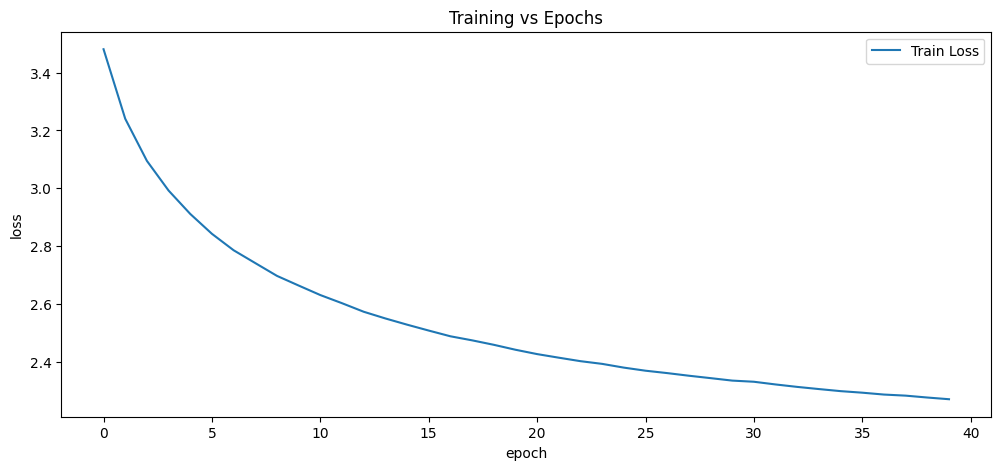

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.title(f'Training vs Epochs')
plt.plot(loss_resnet,label='Train Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
model.save('model_resnet40.h5')

In [ ]:
model.optimizer.lr = 0.0001
epochs = 40
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath
loss=[]

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    history=model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    loss.append(history.history['loss'])
    #model.save('./model_weights/model_' + str(i) + '.h5')

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 63s 57ms/step - loss: 4.7206
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - loss: 3.5498
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - loss: 3.2751
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - loss: 3.1184
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - loss: 3.0055
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - loss: 2.9194
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - loss: 2.8478
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - loss: 2.7868
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - loss: 2.7375
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 2.7007
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 2.6606
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 57ms/step - loss: 2.6287
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - loss: 2.5953
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - loss: 2.5693
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - loss: 2.5432
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 58s 58ms/step - loss: 2.5266
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/

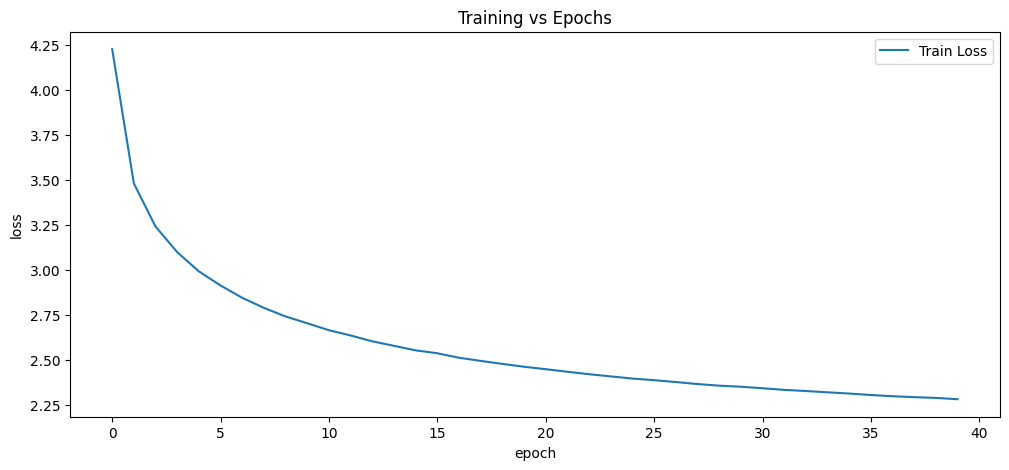

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.title(f'Training vs Epochs')
plt.plot(loss,label='Train Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
model.save('model_40.h5')

In [ ]:
model.load_weights('model_40.h5')

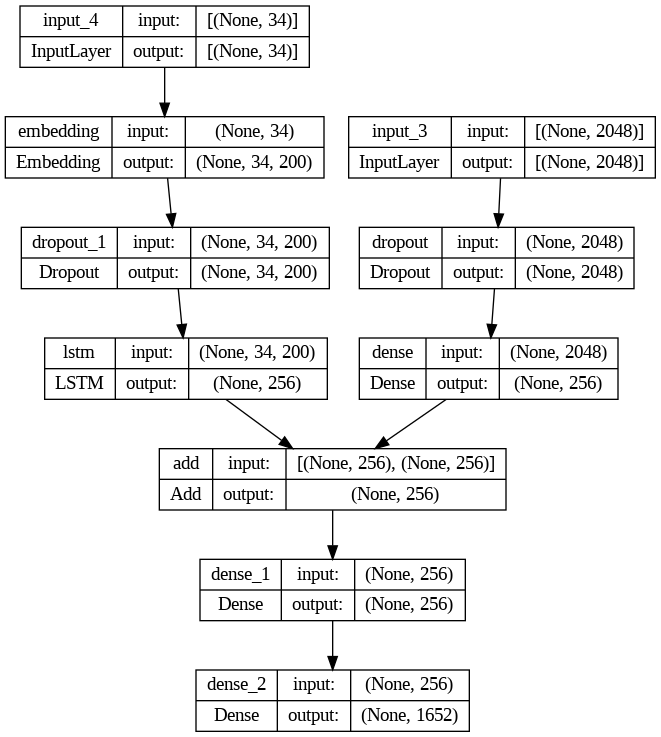

In [31]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
with open("/kaggle/input/pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

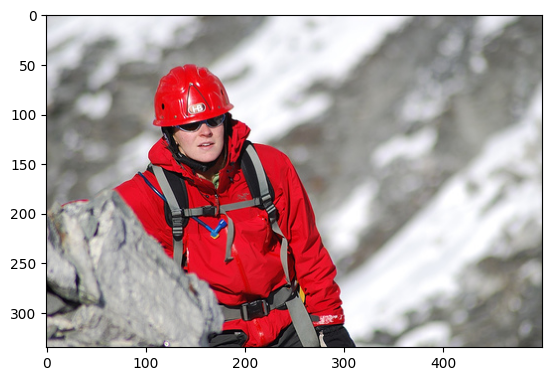

Greedy: man in red jacket climbing rock


In [ ]:
z=10
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [ ]:
!pip install nltk


In [ ]:
import nltk
nltk.download('punkt') # For tokenization


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu


In [ ]:
dict_len=len(encoding_test.keys())
dict_len

1000

In [ ]:
cap_img=[]
for z in range(0,dict_len):
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,2048))
  grd=greedySearch(image)
  cap_img.append(grd)



In [ ]:
final_caps=[]

In [ ]:
ref_captions=[]
for des in test_descriptions.values():

  for d in des:
    ref_captions.append(d[9:-7])
  final_caps.append(ref_captions)
  ref_captions=[]



In [ ]:
len(test_descriptions.values())

1000

In [ ]:
#bleau score implementation
image_list=img
reference_captions=final_caps
predicted_captions=cap_img



In [ ]:
len(reference_captions)

1000

In [ ]:
reference_captions[1]

['boy in his blue swim shorts at the beach',
 'boy smiles for the camera at beach',
 'young boy in swimming trunks is walking with his arms outstretched on the beach',
 'children playing on the beach',
 'the boy is playing on the shore of an ocean']

In [ ]:
len(predicted_captions)

1000

In [ ]:
predicted_captions[5]

'black poodle with red collar is running through the grass'

In [ ]:
# Tokenize Captions (convert to lists of words)
tokenized_refs = [[nltk.word_tokenize(cap) for cap in image_refs] for image_refs in reference_captions]
tokenized_preds = [nltk.word_tokenize(cap) for cap in predicted_captions]



In [ ]:
# Calculate Individual Image BLEU
individual_bleu_scores = []
name=[]
number=[]

for i in range(len(reference_captions)):
    image_score = sentence_bleu(tokenized_refs[i], tokenized_preds[i])
    individual_bleu_scores.append(image_score)
    if image_score>0.8:
      name.append(reference_captions[i])
      number.append(i)

In [ ]:
average_bleu = sum(individual_bleu_scores) / len(individual_bleu_scores)
print(f"Average BLEU Score (per image): {average_bleu}")


Average BLEU Score (per image): 0.5451754350417504


In [ ]:
individual_bleu_scores.sort(reverse=True)

In [ ]:
individual_bleu_scores[0:11]

[0.9193227152249185,
 0.8801117367933934,
 0.8694417438899827,
 0.8694417438899827,
 0.8694417438899827,
 0.8694417438899827,
 0.8593887047640296,
 0.8408964152537145,
 0.8408964152537145,
 0.8408964152537145,
 0.8408964152537145]

In [ ]:
len(number)
number.sort()

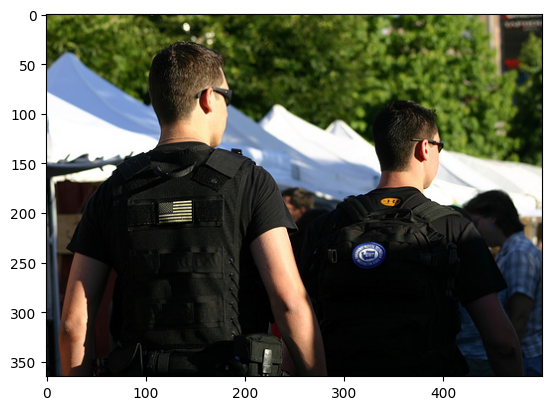

Greedy: man with beard and beard is smiling
Bleu Score of the Image is: 0.8694417438899827




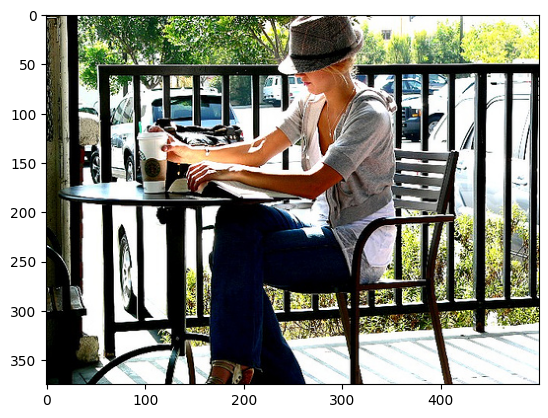

Greedy: man in white robe and jeans is sitting on bench
Bleu Score of the Image is: 0.8408964152537145




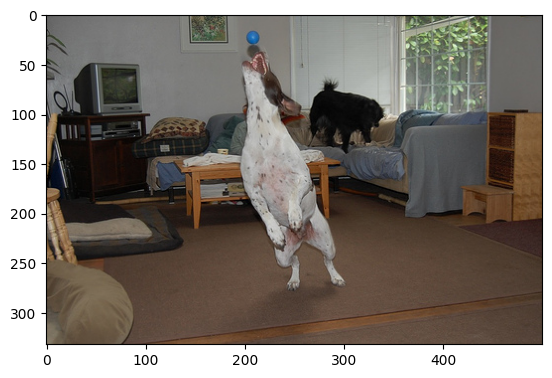

Greedy: two dogs are tied on the bed
Bleu Score of the Image is: 0.8091067115702212




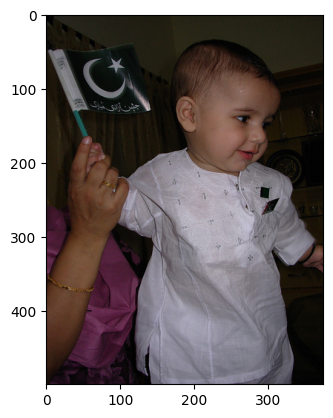

Greedy: the boy is wearing red shirt and holding blue bottle
Bleu Score of the Image is: 0.8408964152537145




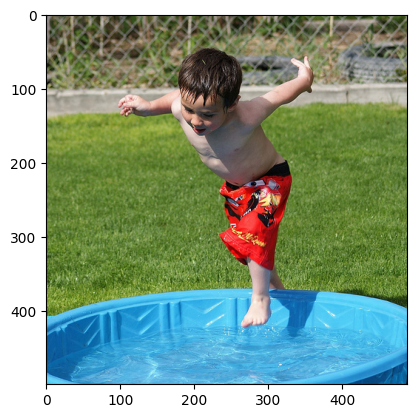

Greedy: boy in blue shorts jumps into pool
Bleu Score of the Image is: 0.8091067115702212




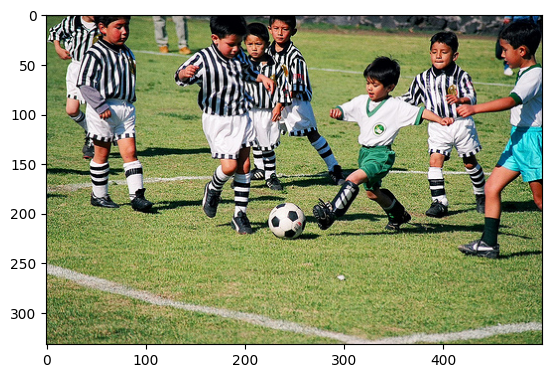

Greedy: two boys play soccer on the grass
Bleu Score of the Image is: 0.8091067115702212




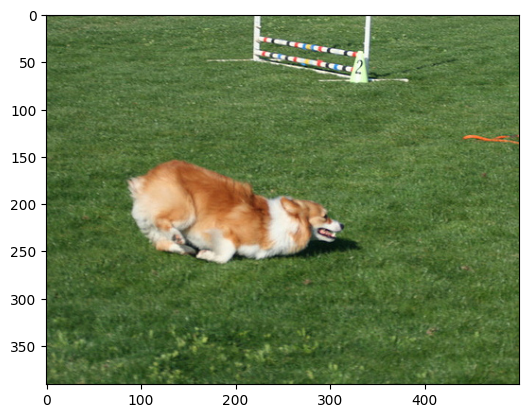

Greedy: two little boys are playing with sticks in the grass
Bleu Score of the Image is: 0.8801117367933934




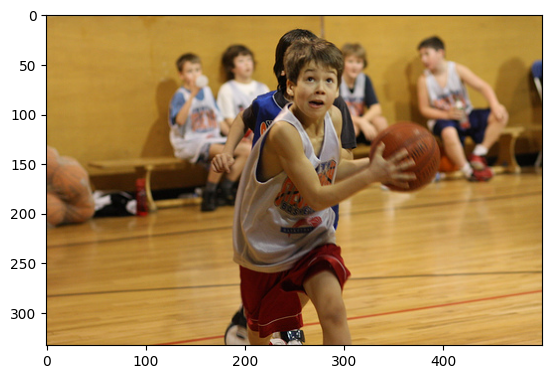

Greedy: boy in blue shirt is running with ball in his hand
Bleu Score of the Image is: 0.8210967436686386




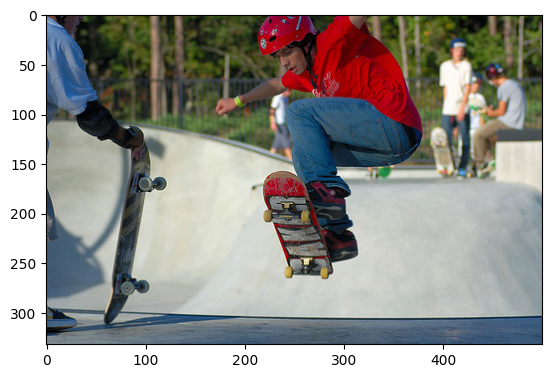

Greedy: the child is wearing red helmet and holding ice
Bleu Score of the Image is: 0.816496580927726




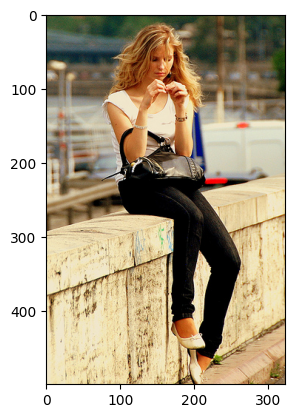

Greedy: woman in red shirt and tank top crossing road
Bleu Score of the Image is: 0.816496580927726




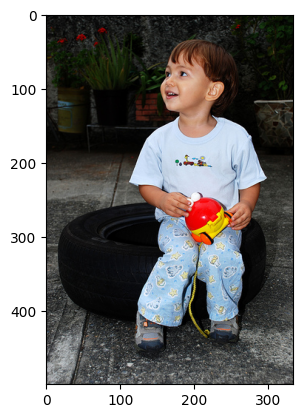

Greedy: child in red coat is playing with toy
Bleu Score of the Image is: 0.8408964152537145




In [ ]:
number.sort(reverse=True)

for z in number[:11]:
  image_score_final = sentence_bleu(tokenized_refs[z], tokenized_preds[z])

  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  print("Greedy:",greedySearch(image))
  print(f'Bleu Score of the Image is: {image_score_final}')
  print('\n')
